In [7]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import mplstylize
import seaborn as sns
from scipy.constants import c, pi
from scipy.integrate import solve_ivp
from scipy.special import erf

from acoustic_resonators.stroboscopy.config import paths

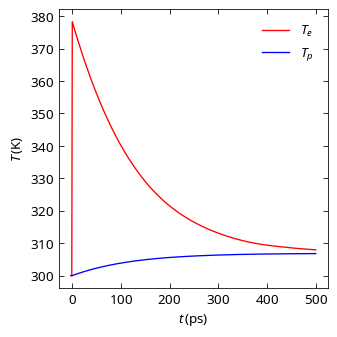

In [2]:
P_av = 2e-3  # Average power [W]
f_rep = 1e3  # Repetition frequency [Hz]
τ = 110e-3 * 1.5  # Pulse width [ps]
w = 2.3e-3  # Beam waist [m]
d = 21.7e-9  # Film thickness [m]
lda = 800e-9  # Wavelength [m]
ns = 1.4305  # Index of refraction, CaF2

F_peak = P_av / (f_rep * pi * w**2 / 2)


def absorptance(k, n, κ, d):
    x = 2 * k * d * κ * n
    return 4 * x / (1 + ns + x) ** 2


k = 2 * pi / 640e-9
P_pulse = F_peak * absorptance(k, 1.96, 0.96, d) / (d * τ)  # [J/m^3/ps]


def gaussian(t, tau):
    sig = tau / (2 * np.sqrt(2 * np.log(2)))
    return 1 / (sig * np.sqrt(2 * pi)) * np.exp(-(t**2) / (2 * sig**2))


def twotemp(t, T, G, a, C_l, P):
    dTdt = np.zeros(2)
    dTdt[0] = (1 / (a * T[0])) * (P * gaussian(t, τ) - G * (T[0] - T[1]))
    dTdt[1] = (1 / C_l) * (G * (T[0] - T[1]))
    return dTdt


T0 = [300.0, 300.0]
tspan = (-2, 500)

G, a, C_l = 2000, 800, 2.85e6  # (Pa/ps/K, Pa/K^2, Pa/K)


def solve_twotemp(tspan, G, a, C_l, P):
    return solve_ivp(
        twotemp,
        tspan,
        T0,
        method="DOP853",
        dense_output=True,
        first_step=1e-4,
        args=(G, a, C_l, P),
    )


sol = solve_twotemp(tspan, G, a, C_l, P_pulse)

# Plotting
t = np.linspace(*tspan, 1000)
T_e, T_p = sol.sol(t)

fig = plt.figure(figsize=(3.4, 3.4))
ax = fig.add_subplot(111)
ax.plot(t, T_e, "r-", label=r"$T_e$")
ax.plot(t, T_p, "b-", label=r"$T_p$")
ax.set(xlabel=r"$t\,(\mathrm{ps})$", ylabel=r"$T\,(\mathrm{K})$")
ax.legend()
plt.show()

[None]

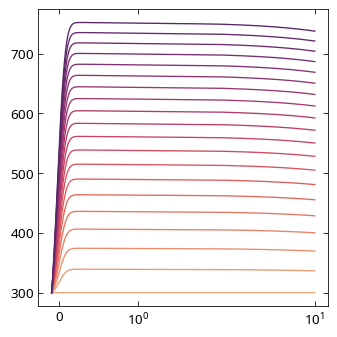

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

tspan = (-0.1, 10)
N = 20
P_list = np.linspace(0, 10 * P_pulse, N)
maxima = np.zeros(N)
colors = sns.color_palette("flare", n_colors=N)
for i, P in enumerate(P_list):
    sol = solve_twotemp(tspan, G, a, C_l, P)
    t = np.linspace(*tspan, 10_000)
    T_e, T_p = sol.sol(t)
    ax.plot(t, T_e, color=colors[i])
    maxima[i] = T_e.max()
ax.set(xscale="symlog")

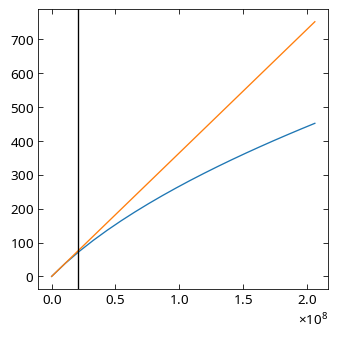

In [35]:
plt.plot(P_list, maxima - maxima[0])
plt.plot(P_list, np.max(maxima) * P_list / np.max(P_list))
plt.axvline(x=P_pulse, c="k")

[Text(0.5, 0, '$P$ (Pa)'), Text(0, 0.5, 'ΔT')]

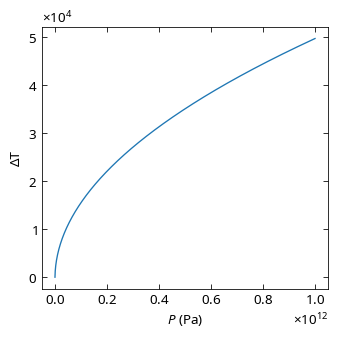

In [66]:
T_0 = 300
Q = np.linspace(0, 1e12, 1000)
dT = 1/a * (np.sqrt(a * (a * T_0**2 + 2*Q)) - a*T_0)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
ax.plot(Q, dT)
ax.set(xlabel=r"$P$ (Pa)", ylabel="ΔT")